# Question 6

### Libraries

In [1]:
import pandas as pd
from random import seed
from random import randrange
from random import random
from random import *
from csv import reader
from math import exp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as py

### a) Import data

**Dataset directory path**

In [2]:
#For Windows use 'r' in front of the string
path = "/Users/lunguteodor/OneDrive/Documents/Facultate/2021-2022 (Third Year)/Quarter 2 (2021-2022)/Data Mining/2IIG0---Data-Mining-and-Machine-Learning/HW2/data/"

**Load dataset**

In [3]:
train_data = pd.read_csv(path + "train_data.csv")
validate_data = pd.read_csv(path + "validate_data.csv")

**Explore dataset**

In [4]:
train_data.head()

,X_1,X_2,y
0,2917.211242,3289.522533,0
1,1888.937716,781.528356,0
2,4188.521414,1554.476261,0
3,8145.555339,9804.066728,0
4,9584.488981,6176.337189,0


In [5]:
train_data.describe()

,X_1,X_2,y
count,410.000000,410.000000,410.000000
mean,4895.705237,4973.234806,0.500000
std,2860.877356,3119.801712,0.500611
min,27.557777,29.069434,0.000000
25%,2341.140941,2124.504836,0.000000
50%,4987.225191,5701.130455,0.500000
75%,7303.607081,7762.583984,1.000000
max,9941.145899,9960.403013,1.000000


### b) Data normalization

We use minmax of data normalization.

### c) Size of input/output layers

Since there are 2 features, we'll have 2 inputs, hence 2x10 connections with the first hidden layer. Because there are 2 classes, then we'll have two neurons in the last layer.

### d) Loss function & activation function

We choose for activation we can use either ReLU or sigmoid.

### e) Initialization of the parameter values

We initialize the weights randomly.

### f) Implement MLP & g) Tune hyperparameters

Load data into a list

In [6]:
def load_csv_file(path):
	data = list()
	with open(path, 'r') as file:
		file_reader = reader(file)

		for i in file_reader:
			if not i:
				continue

			data.append(i)

	return data

Utility functions

In [7]:
#For the feature columns: convert string to float
def convert_float(data, feature):
	for line in data:
		line[feature] = float(line[feature].strip())

#For the classes column: convert string to int
def convert_int(data, feature):
	for line in data:
		line[feature] = int(line[feature].strip())

Normalize data with MinMax

In [8]:
def normalize_data_minmax(data):
	min_and_max = [[min(feature), max(feature)] for feature in zip(*data)]
	for obs in data:
		for i in range(len(obs)-1):
			obs[i] = (obs[i] - min_and_max[i][0]) / (min_and_max[i][1] - min_and_max[i][0])

Load, convert and normalize a dataset

In [9]:
def prepare_data(path):
	datafile = path
	data = load_csv_file(datafile)
	data = data[1:]
	for i in range(len(data[0])-1):
		convert_float(data, i)
	convert_int(data, len(data[0])-1)
	normalize_data_minmax(data)
	return data

Evaluate accuracy of a neural network

In [10]:
def evaluate_accuracy(trainset, validationset, algorithm, *args):
	outputs = algorithm(trainset, validationset, *args)
	groundtruth = [line[-1] for line in validationset]
	accuracy = compute_accuracy(groundtruth, outputs[0])
	return accuracy, outputs

In [11]:
def compute_accuracy(groundtruth, outputs):
	counter = 0
	for line in range(len(groundtruth)):
		if groundtruth[line] == outputs[line]:
			counter += 1
	return counter / float(len(groundtruth)) * 100.0

Declare, define, run and collect outputs of a neural network

In [12]:
def algorithm(trainset, validationset, lr, epochs, n_hidden, batches):
    #Number of I/O
	inputs = len(trainset[0]) - 1
	outputs = len(set([line[-1] for line in trainset]))

    #Retrieve neural network
	network = init_neuralnet(inputs, n_hidden, outputs)
	errors = train_network(network, trainset, lr, epochs, outputs, batches)

    #Run on validation set
	validation_results = list()
	for line in validationset:
		guess = classify_observation(network, line)
		validation_results.append(guess)
		
	return validation_results, errors

In [13]:
# Predicts the class of an observation
# Pass forward and pick the best prediction
def classify_observation(network, row):
	outputs = forward_pass(network, row)
	return outputs.index(max(outputs))

Initialize network with 2 hidden layers and an output layer

In [14]:
def init_neuralnet(nrof_inputs, nrof_neurons_hidden, nrof_outputs):
	neuralnet = list()
	hidden_layer_first = [{'weights':[random() for i in range(nrof_inputs + 1)]} for i in range(nrof_neurons_hidden)]
	neuralnet.append(hidden_layer_first)

	hidden_layer_second = [{'weights':[random() for i in range(nrof_neurons_hidden + 1)]} for i in range(nrof_neurons_hidden)]
	neuralnet.append(hidden_layer_second)

	output_layer = [{'weights':[random() for i in range(nrof_neurons_hidden + 1)]} for i in range(nrof_outputs)]
	neuralnet.append(output_layer)

	return neuralnet

Train without batches, only SGD

In [15]:
def train_network_SGD(network, training_dataset, learning_rate, nrof_epochs, nrof_outputs, dummy):
	errors = list()

	for epoch in range(nrof_epochs):
		error = 0

		for observation in training_dataset:
			outputs = forward_pass(network, observation)
			groundtruths = [0 for i in range(nrof_outputs)]
			groundtruths[observation[-1]] = 1
			error += sum([(groundtruths[i] - outputs[i]) ** 2 for i in range(len(groundtruths))])
			
			backward_pass(network, groundtruths)
			update_weights(network, observation, learning_rate)

		print('>epoch=%d, error=%.3f' % (epoch, error))
		errors.append(error)
	
	return errors

Train with batches

In [16]:
def train_network(neuralnet, train, learning_rate, nrof_epochs, nrof_outputs, batch_size):
	errors = list()
	for epoch in range(nrof_epochs):
		batch_error = 0
		for batch in make_batches(train, batch_size=batch_size):
			error = 0
			for line in batch:
				outputs = forward_pass(neuralnet, line)
				groundtruths = [0 for i in range(nrof_outputs)]
				groundtruths[line[-1]] = 1
				error += sum([(groundtruths[i] - outputs[i]) ** 2 for i in range(len(groundtruths))])
				backward_pass(neuralnet, groundtruths)
				
			for row in batch:
				update_weights(neuralnet, row, learning_rate)
			batch_error += error
		errors.append(batch_error/batch_size)
		print(epoch)
	
	return errors

In [17]:
def make_batches(iterable, batch_size=1):
    n = len(iterable)
    for i in range(0, n, batch_size):
        yield iterable[i:min(i + batch_size, n)]

Forward pass, backward pass, update weights

In [18]:
def forward_pass(neuralnet, row):
	inputs = row
	for layer in neuralnet:
		new_inputs = []
		for neuron in layer:
			neuron['output'] = activation(sum_weight_input(neuron['weights'], inputs))
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs

In [19]:
def backward_pass(neuralnet, expected):
	for i in reversed(range(len(neuralnet))):
		layer = neuralnet[i]
		errors = list()
		if i != len(neuralnet)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in neuralnet[i + 1]:
					error += (neuron['weights'][j] * neuron['weight_change'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(neuron['output'] - expected[j])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['weight_change'] = errors[j] * activation_derivative(neuron['output'])

In [20]:
def update_weights(neuralnet, line, l_rate):
	for i in range(len(neuralnet)):
		inputs = line[:-1]
		
		if i != 0:
			inputs = [neuron['output'] for neuron in neuralnet[i - 1]]

		for neuron in neuralnet[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] -= l_rate * neuron['weight_change'] * inputs[j]
			neuron['weights'][-1] -= l_rate * neuron['weight_change']

Activation sum of weights * input

In [21]:
def sum_weight_input(weights, inputs):
	y = weights[-1]
	for i in range(len(weights)-1):
		y += weights[i] * inputs[i]
	return y

Activation function: ReLU

In [22]:
def activation(swi):
	return max(0, swi)

In [23]:
def activation_derivative(output):
    if output <= 0:
        return 0
    else:
        return 1

Run

In [24]:
train_path = '/Users/lunguteodor/OneDrive/Documents/Facultate/2021-2022 (Third Year)/Quarter 2 (2021-2022)/Data Mining/2IIG0---Data-Mining-and-Machine-Learning/HW2/data/train_data.csv'
validate_path = '/Users/lunguteodor/OneDrive/Documents/Facultate/2021-2022 (Third Year)/Quarter 2 (2021-2022)/Data Mining/2IIG0---Data-Mining-and-Machine-Learning/HW2/data/validate_data.csv'

In [25]:
dataset = prepare_data(train_path)
testset = prepare_data(validate_path)
dataset

[[0.29148411546616415, 0.3282996259301394, 0],
 [0.18776046734102808, 0.07576615122002546, 0],
 [0.41972327129796977, 0.15359536711078225, 0],
 [0.8188758159059557, 0.9842582787339653, 0],
 [0.9640234278831104, 0.618977069502859, 0],
 [0.4047047275405339, 0.013949557474687862, 0],
 [0.23921338819416202, 0.6265847570706259, 1],
 [0.5923505178588698, 0.7756707880883303, 0],
 [0.1820692960610651, 0.12804532501597507, 0],
 [0.1598544521221301, 0.6441946872587039, 1],
 [0.9339775979231282, 0.15444922112067727, 1],
 [0.8543409374826657, 0.8837796383714998, 0],
 [0.9408962572579236, 0.9884350286810096, 0],
 [0.6992537188979283, 0.7115794899822552, 1],
 [0.836348688681416, 0.657758424487849, 0],
 [0.2954324980819442, 0.17272054063253303, 0],
 [0.34969811577677634, 0.7196033403913101, 1],
 [0.9790650339260872, 0.01947117873169356, 1],
 [0.3358849324653488, 0.9170507088045807, 1],
 [0.14517816093342345, 0.7661268085969148, 0],
 [0.23015567035304924, 0.28822853136504534, 0],
 [0.16273924052051011

In [26]:
#lr = 0.0002, batch_size = 10, nrof_epochs = 800 => 95%
# relu \w l_rate = 0.001 & n_epochs = 800 => 97%
learning_rate = 0.0002
nrof_epochs = 800
nrof_hidden_neurons = 10 #Nr of neurons in one hidden layer
batch_size = 10 #For training with batches
results = evaluate_accuracy(dataset, testset, algorithm, learning_rate, nrof_epochs, nrof_hidden_neurons, batch_size)
print('Accuracy: %s' % results[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### h) Plots

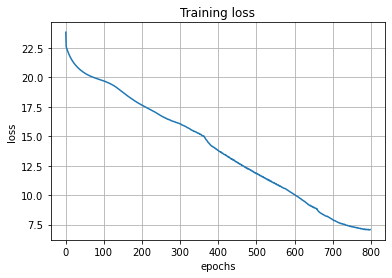

In [38]:
fig, ax = plt.subplots()
ax.plot(list(range(nrof_epochs - 1)), results[1][1][1:])
ax.set(xlabel='epochs', ylabel='loss',
       title='Training loss')
ax.grid()
plt.show()

### i) Confusion matrix

In [39]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0

for i in range(len(testset)):
    if testset[i][2] == results[1][0][i]:
        if testset[i][2] == 1:
            true_pos += 1
        else:
            true_neg += 1
    else:
        if testset[i][2] == 1:
            false_neg += 1
        else:
            false_pos += 1

matrix = [[true_pos, true_neg], [false_pos, false_neg]]

print(matrix)
    
    

[[39, 39], [2, 2]]


# Skeleton code - UNUSED

In [29]:
# To DO
# implement the activation and its derivative

#ReLU
def activation(x):
    return max(0, x)

def activation_derivative(x):
    if x < 0:
        return 0
    if x > 0:
        return 1

    return 0

In [30]:
# To DO 
# implement the loss its derivative
def compute_loss(predicted_op, true_y):
    loss = 0
    return loss

def loss_derivative(x):
    return 

In [31]:
# TO DO 
# organize the training data into batches
def make_batches(x_train, y_train, batch_size):
    
    return x_batches, y_batches

In [32]:
# TO DO 
def forward_pass(x_batch, y_batch):

  return predicted_op


In [33]:
# TO DO 
def backward_pass(loss):

  return grads

In [34]:
#TO DO
def update_weights(weights, grads, lr):

  return

In [35]:
# To Do
# define you stopping criteria for training
def stopping_criteria():
  stop = False
  return stop

In [36]:
# TO DO
# Define the hyperparameters. Add any additional hyperparameters you might need
lr = 0  # learning rate
batch_size = 0
num_epochs = 0

In [37]:
def train(x_train, y_train, lr, batch_size, num_epochs):

  while not stopping_criteria():
      # TO DO 
      # get a batch from the data
      x_batch, y_batch = [], []

      # forward the batch through the network layers
      predicted_op = forward_pass(x_batch)

      # compute the loss
      loss = compute_loss(predicted_op, y_batch)

      # perform backward pass
      grads = backward_pass(loss)

      # update the weights of the network
      update_weights(network, grads, lr)
